In [335]:
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd
import numpy as np
from code_exercise1 import my_windowing, get_index_from_time, get_fundamental_frequency
from code_exercise2 import plot_spectrogram

threshold = 80


def load_audio(file_path: str) -> [np.ndarray, int]:
    """
    Load an audio file.

    :param file_path: path to the audio file
    :return: a tuple containing
        - the audio data
        - the sampling rate
    """
    return sf.read(file_path)

def compute_power(signal_segment: np.ndarray) -> int:
    """
    Compute the power of a signal segment.

    :param signal_segment: the signal segment
    :return: the power of the signal segment
    """
    return np.sum(signal_segment**2)

def compute_power_for_all_frames(m_frames: np.ndarray) -> np.ndarray:
    """
    Compute the power for all frames.

    :param m_frames: matrix containing the frames
    :return: a vector containing the power for all frames
    """
    return np.apply_along_axis(compute_power, 1, m_frames)

def count_zero_crossings(signal_segment: np.ndarray) -> np.ndarray:
    """
    Count the zero crossings in a signal segment.

    :param signal_segment: the signal segment
    :return: the number of zero crossings
    """
    return np.sum(np.where(signal_segment*np.roll(signal_segment, 1)<=0, 1, 0))

def is_voiced(signal_segments: np.ndarray) -> np.ndarray:
    """
    Check if a signal segment is voiced.

    :param signal_segments: the signal segments
    :return: 1 if the signal segment is voiced, 0 otherwise
    """

    return get_number_of_zero_crossings(signal_segments) < threshold

def get_number_of_zero_crossings(signal) -> np.ndarray:
    """
    Get the number of zero crossings for all frames.

    :param signal: the signal
    :return: a vector containing the number of zero crossings for all frames
    """
    return np.apply_along_axis(count_zero_crossings, 1, signal)

    


# 2 LPC-Vocoder: Analysis

## 2.1 Segmentation

Why do we segment the signal prior to analysis instead of processing the whole signal at once?

- more detailed: we want to detect the different vowels and consonants in the signal in time
- analyzing bigger segments needs more frequencies -> more data -> more computation time

Is a segment length of 32 ms appropriate? Why or why not?

- convert_to_samples(32, fs) = 256 sampels 
- tradeoff between time resolution and frequency resolution

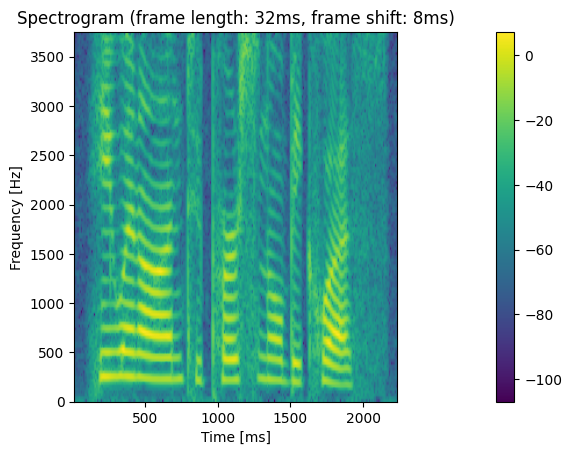

In [336]:
# 2.2.1
x, fs = load_audio('Audio/female8khz.wav')
N = 32
R = 8  # segment shift
L = N - R 
m_frames, v_time_frame = my_windowing(x, fs, N, R)

plot_spectrogram(x, fs, N, R)

sd.play(x, fs)
sd.wait()

## 2.2 Signal Power

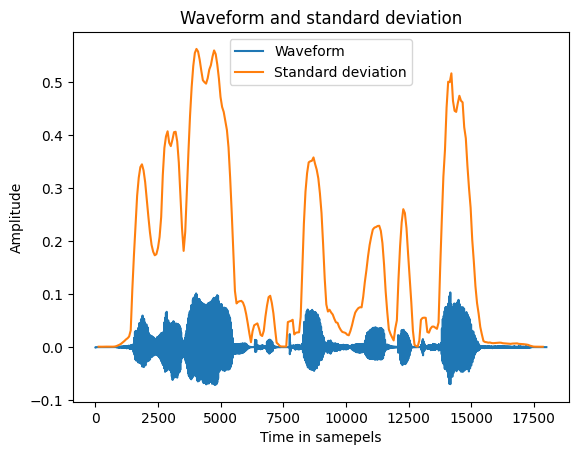

<Figure size 640x480 with 0 Axes>

In [337]:
# 2.2.2
# Compute the power of each frame
v_power = compute_power_for_all_frames(m_frames)
# standrad deviation
v_std = np.sqrt(v_power)
# plot waveform and v_std
plt.plot(x, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), v_std, label='Standard deviation')
plt.title('Waveform and standard deviation')
plt.xlabel('Time in samepels')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
plt.clf()

## 2.3 Voiced/Unvoiced Decision

Explain differences in the creation of speech for voiced and unvoiced sounds.
- voiced sounds: vocal cords vibrate -> periodic signal
- unvoiced sounds: turbulent airflow -> aperiodic signal aka noise (more zero crossings)

Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
- voiced sounds: less zero crossings
- unvoiced sounds: more zero crossings

Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in Python?
 - sample[i] * sample[i+1] < 0 oder ein schritt in der auto correlation: np.sum(np.sign(sample* sample.shift(1)))

Appropriate threshold for the zero crossing number?
- 80 zero crossings

Are all speech sounds either voiced or unvoiced?
- no, there are also mixed sounds (e.g. fricatives)


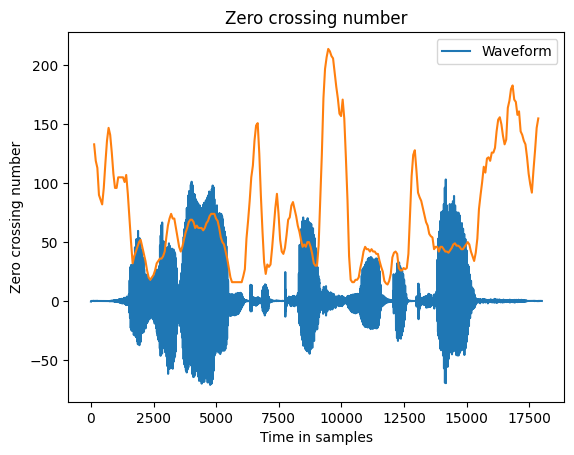

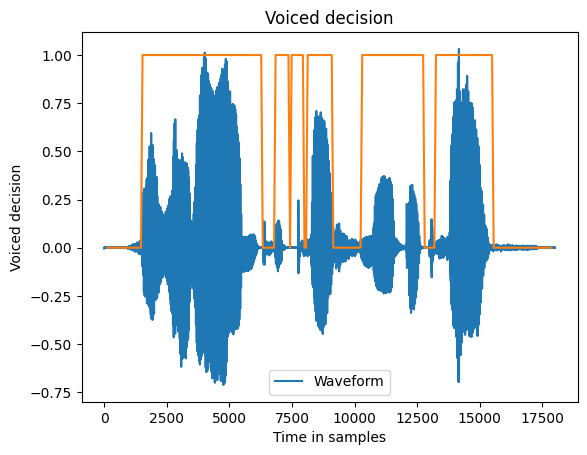

<Figure size 640x480 with 0 Axes>

In [338]:
# 2.2.3

zero_crossing_number = get_number_of_zero_crossings(m_frames)
plt.plot(x*1000, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), zero_crossing_number)
plt.title('Zero crossing number')
plt.xlabel('Time in samples')
plt.ylabel('Zero crossing number')
plt.legend()
plt.show()
plt.clf()

voiced_decision = is_voiced(m_frames)
plt.plot(x*10, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), voiced_decision)
plt.title('Voiced decision')
plt.xlabel('Time in samples')
plt.ylabel('Voiced decision')
plt.legend()
plt.show()
plt.clf()

## 2.4 Fundamental Frequency Estimation


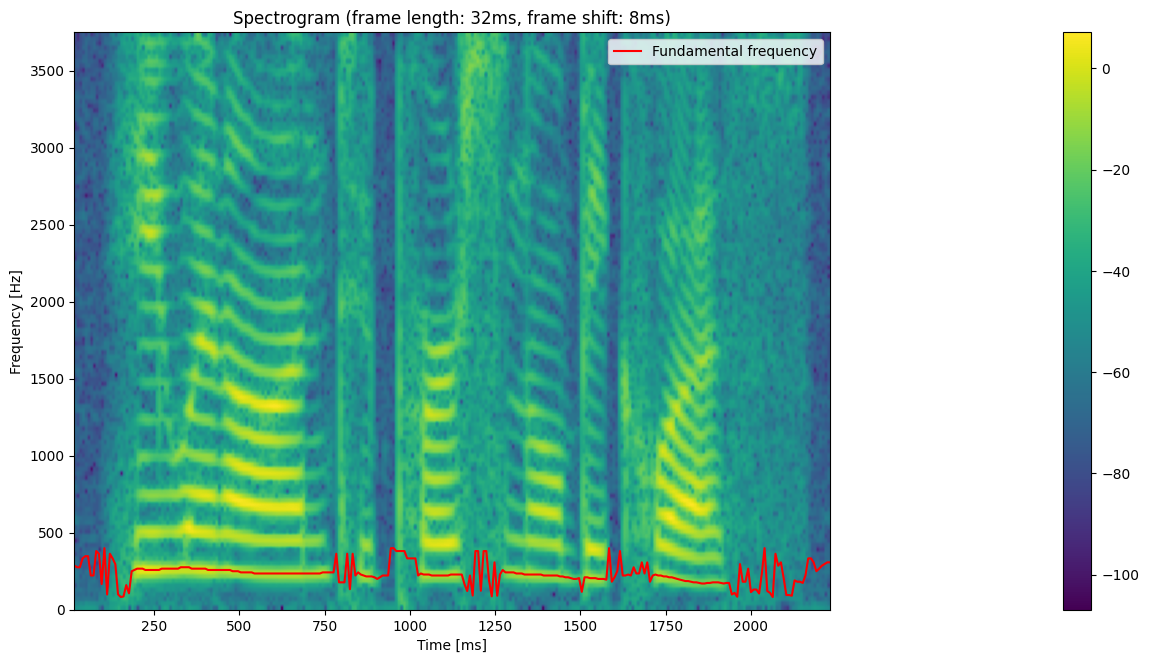

In [339]:
def estimate_f0(signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> np.ndarray:
    """
    Estimate the fundamental frequency of a signal.
    
    :param signal: Input signal
    :param sampling_rate: sampling rate
    :param frame_length: Frame length
    :param frame_shift: Frame shift
    :return: a vector containing the estimated fundamental frequency for each frame
    """
    return np.apply_along_axis(get_fundamental_frequency, 0, signal, sampling_rate, frame_length, frame_shift)


freq_estimate, v_time_frames = estimate_f0(x, fs, N, R)

fig = plt.figure(figsize=(15, 7.5))
ax = fig.add_subplot(111)
plot_spectrogram(x, fs, N, R, ax=ax, fig=fig)
plt.plot(v_time_frames, freq_estimate, label='Fundamental frequency', color='r')
plt.legend()
plt.show()

## 2.5 Linear prediction coefficients / linear predictive coding

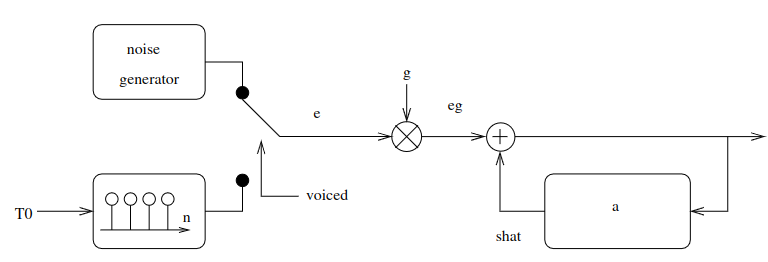

Voiced speech: Impulse train with Fundamental Period T_0
Unvoiced speech: random noise
-> This is our source signal e

After that the gain g ist multiplied (b_0 for the Filter).

Then the recursive Filter is added (a_i coefficients).


In [340]:
from code_exercise3 import compute_LP_coefficients

def compute_lpc(m_frames: np.ndarray, order: int):
    """
    Compute the linear prediction coefficients for a set of frames.
    
    :param m_frames: Input frames 
    :param order: Order of the linear prediction model
    :return: Matrix containing the linear prediction coefficients for all frames (shape: number of frames x order)
    """
    M_lpc = np.apply_along_axis(compute_LP_coefficients, 1, m_frames, order)
    assert M_lpc.shape == (m_frames.shape[0], order)
    return M_lpc

Choose a suitable model order M for linear prediction for a signal with an audio bandwidth of 4 kHz. Give reasons for your choice.
- Slide 193: filter order = sampling frequency +2 , d.h. 8+2 = 10


# 3 LPC-Vocoder: Synthesis

## 3.1 LPCs and constant excitation signal

### Create a voiced and an unvoiced excitation signal.


In [341]:
from code_exercise1 import get_period_from_freq

def get_input_split_size(signal_length, sampling_rate, frame_length_ms, frame_shift_ms):
    """
    Calculate the number of frames that fit into the signal.
    
    :param signal_length: Length of the signal in samples 
    :param sampling_rate: Sampling rate of the signal
    :param frame_length_ms: Length of the frame in milliseconds
    :param frame_shift_ms: Shift of the frame in milliseconds
    :return: 
    """
    frame_length_seconds = frame_length_ms / 1000
    frame_length_samples = get_index_from_time(frame_length_seconds, sampling_rate)
    frame_length_seconds = frame_shift_ms / 1000
    frame_shift_samples = get_index_from_time(frame_length_seconds, sampling_rate)
    # wir gucken, wie viele frame_shifts in das singal passsen, aber müssen aufpassen, dass es gross genug ist für die frame_length_to_ticks
    return (signal_length - frame_length_samples) // frame_shift_samples + 1

def get_unvoiced_signal(sampels: int):
    """
    Get excitation signal for unvoiced segments.
    
    :param sampels: Length of the signal
    :return: Excitation signal
    """
    return np.random.rand(sampels)

def get_voiced_signal(sampels: int, sampling_rate: int = 8000, f0 : int =100, template=False):
    """
    Get excitation signal for voiced segments.
    The signal is a dirac impulse train with a period of f0.
    
    :param sampels: Length of the signal 
    :param sampling_rate: Sampling rate
    :param f0: Fundamental frequency
    :param template: Use a template signal if True
    :return: Excitation signal
    """
    voiced_ex = np.zeros(sampels)
    if not template:
        voiced_ex[::get_period_from_freq(f0, sampling_rate)] = 1
    return voiced_ex

def segment_signal(signal: np.ndarray, frame_shift: int) -> np.ndarray:
    """
    Segment a signal into frames.
    
    :param signal: Input signal 
    :param frame_shift: Frame shift
    :return: Segmented signal
    """
    # Calculate the number of samples per segment
    segment_length = int(frame_shift * fs / 1000)  # Convert milliseconds to samples

    # Determine the total number of segments needed
    num_segments = len(signal) // segment_length

    # Truncate the signal to have an integer number of segments
    truncated_length = num_segments * segment_length
    signal_truncated = signal[:truncated_length]

    # Split the truncated signal into segments
    splits = np.array_split(signal_truncated, num_segments)

    # Verify that all segments have the same size
    assert all(len(segment) == segment_length for segment in splits), "Segments have different sizes"

    return np.array(splits)

# Create excitation signals for voiced and unvoiced segments
voiced_ex = segment_signal(get_voiced_signal(len(x), fs), R)
unvoiced_ex = segment_signal(get_unvoiced_signal(len(x)), R)

### Apply LPC to the excitation signals


In [342]:
from UploadCode.filteradaptively import filter_adaptively


def apply_LPC_to_voiced_unvoiced_e(segmented_voiced, segmented_unvoiced):
    LPCs = compute_lpc(m_frames, 10)
    
    segmented_voiced_output = []
    segmented_unvoiced_output = []
    segmented_combined_output = []
    
    filter_state_voiced = None
    filter_state_unvoiced = None
    
    for i in range(len(LPCs)):
        ar_coeff = np.concatenate(([1], LPCs[i]))
        segment = segmented_voiced[i] #if voiced_decision[i] else segmented_unvoiced[i]
        segment_out, filter_state_voiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_voiced)
        segmented_voiced_output.append(segment_out)
        segment = segmented_unvoiced[i]
        segment_out, filter_state_unvoiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_unvoiced)
        segmented_unvoiced_output.append(segment_out)

        if is_voiced(np.array([m_frames[i]])):
            segmented_combined_output.append(segmented_voiced_output[-1])
        else:
            segmented_combined_output.append(segmented_unvoiced_output[-1])
            
    return np.concatenate(segmented_voiced_output), np.concatenate(segmented_unvoiced_output), np.concatenate(segmented_combined_output)



segmented_voiced_output, segmented_unvoiced_output, segmented_combined_output = apply_LPC_to_voiced_unvoiced_e(voiced_ex, unvoiced_ex)


sd.play(segmented_voiced_output, fs)
sd.wait()

sd.play(segmented_unvoiced_output, fs)
sd.wait()

Listen to both of the signals, voiced only and unvoiced only. Can you understand what is said?
- Yes, in both cases, but the voiced signal is clearer.

## 3.2 Voiced/unvoiced excitation


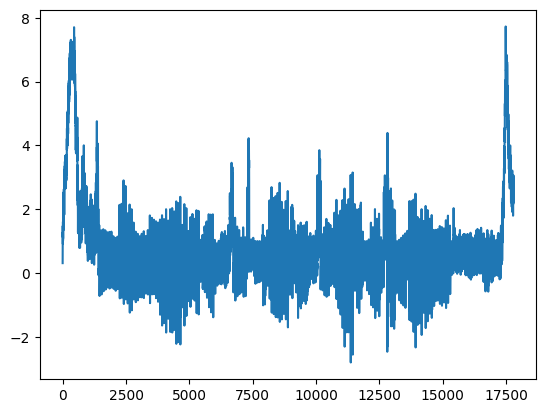

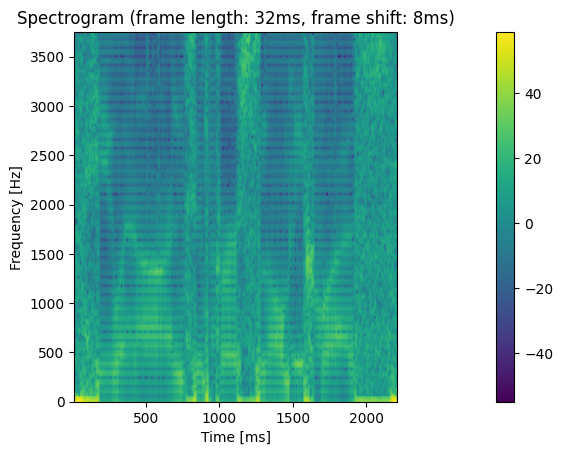

<Axes: title={'center': 'Spectrogram (frame length: 32ms, frame shift: 8ms)'}, xlabel='Time [ms]', ylabel='Frequency [Hz]'>

In [343]:
sd.play(segmented_combined_output, fs)
sd.wait()

plt.plot(segmented_combined_output)
plot_spectrogram(segmented_combined_output, fs, 32, R)

## 3.3 Amplitude modulation

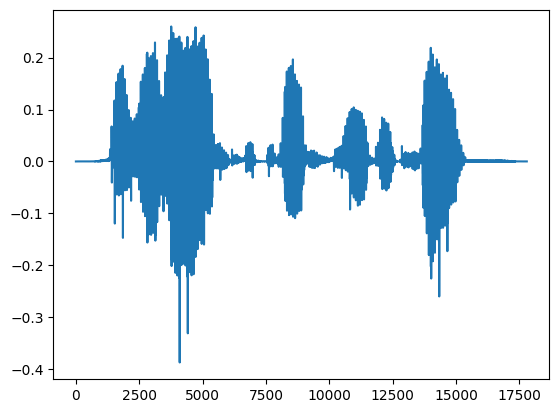

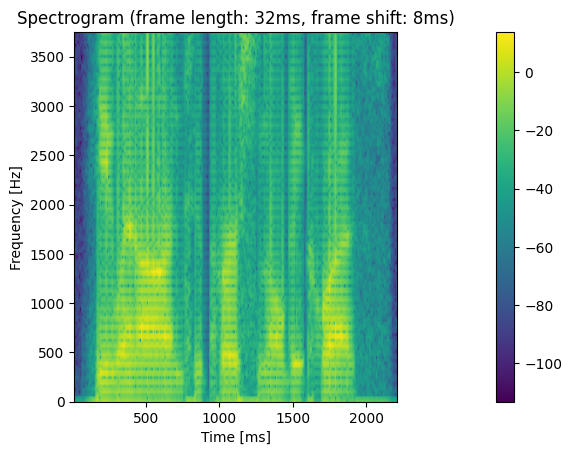

In [344]:
# we have compute power and compute_power_for_all_frames previously defined
def add_gain_to_LPC_signal(segments: np.ndarray, original_power = None):
    """
    Add gain to the LPC signal.
    
    :param segments: 
    :param original_power: 
    :return: 
    """
    if original_power is None:
        original_power = compute_power_for_all_frames(m_frames)
    segment_power = compute_power_for_all_frames(segments)
    #  we want to find x, so that segment*x = original_segment <=> x = original_segment/segment
    factors = np.sqrt(original_power/segment_power)
    return factors


def compute_gain_factor(original_power, segment):
    segment_power = compute_power(segment)
    return np.sqrt(original_power/segment_power)


def apply_LPC_to_voiced_unvoiced_e(LPCs, segmented_voiced, segmented_unvoiced, power_per_segment=None):
    filter_state = None    
    voiced_decision = is_voiced(m_frames)
    
    output = []
    for i in range(len(LPCs)):
        if voiced_decision[i]:
            segment = segmented_voiced[i]
        else:
            segment = segmented_unvoiced[i]


        ar_coeff = np.concatenate(([1], LPCs[i]))
        segment_out, filter_state = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state)
                
        if power_per_segment is None:
            gain = 1
        else:
            segment_power = compute_power(segment_out)
            gain = np.sqrt(power_per_segment[i]/segment_power)
        
        segment_out *= gain
        output.append(segment_out)

    return np.concatenate(output)


voiced_ex = segment_signal(get_voiced_signal(len(x), fs), R)
unvoiced_ex = segment_signal(get_unvoiced_signal(len(x)), R)
LPCs = compute_lpc(m_frames, 10)
power_per_segment = compute_power_for_all_frames(m_frames)

output_with_gain = apply_LPC_to_voiced_unvoiced_e(LPCs, voiced_ex, unvoiced_ex, power_per_segment)

plt.plot(output_with_gain)
plot_spectrogram(output_with_gain, fs, 32, R)
plt.show()

sd.play(output_with_gain, fs)
sd.wait()
# What is the improvement? -> noise inbetwe, m_framesen gets much lower, so you can hear it more clearly


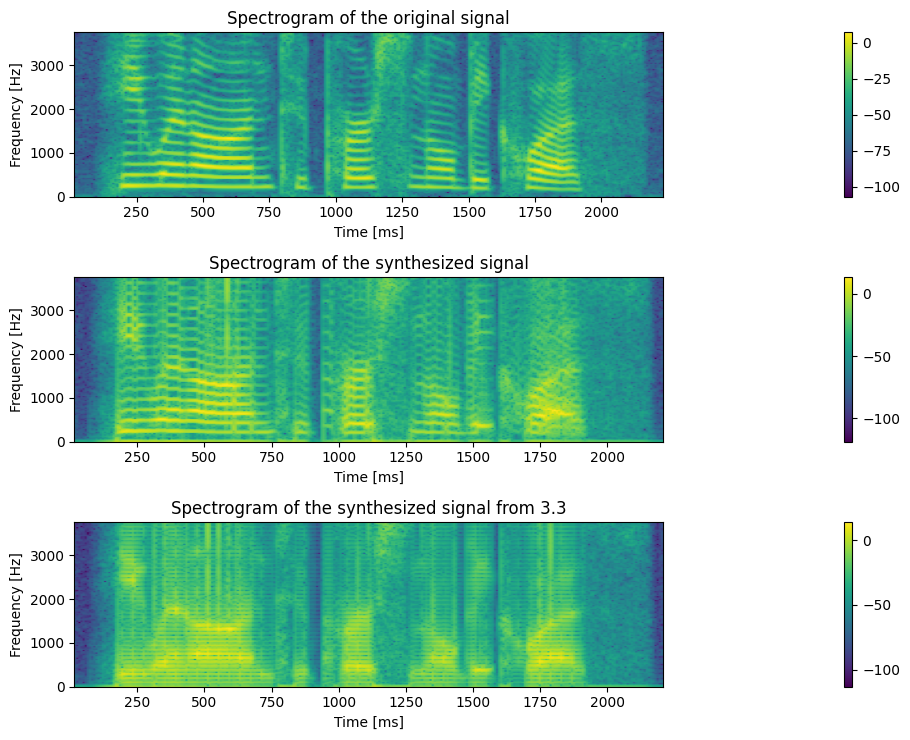

In [345]:
# 3.4
def get_voiced_signal_with_f0(frequencies: np.ndarray, sampling_rate: int, frame_shift: int) -> np.ndarray:
    """
    Process and modify the voiced segments of the signal.
    
    :param sampling_rate: Sampling rate
    :param frame_shift: Frame shift
    :param frequencies: Fundamental frequencies for each frame. If None, they are estimated.
    :return: Modified voiced segments
    """
    segmented_voiced = segment_signal(get_voiced_signal(len(x), sampling_rate, template=True), frame_shift)
    fundamental_periods = [get_period_from_freq(f, sampling_rate) for f in frequencies]
    counter = 0
    # assert len(fundamental_periods) == len(segmented_voiced), f"fundamental period: {len(fundamental_periods)}, segmented_voiced: {len(segmented_voiced)}"
    for j, frame in enumerate(segmented_voiced):
        for i in range(len(frame)):
            counter += 1
            if len(fundamental_periods)>j and counter > fundamental_periods[j]:
                counter = 0
                segmented_voiced[j][i] = 1
    return segmented_voiced


frequencies, _ = get_fundamental_frequency(x, fs, R, R)
unvoiced_ex = segment_signal(get_unvoiced_signal(len(x)), R)
voiced_ex_with_f0 = get_voiced_signal_with_f0(frequencies, fs, R)
LPCs = compute_lpc(m_frames, 10)
power_per_segment = compute_power_for_all_frames(m_frames)

output_with_f = apply_LPC_to_voiced_unvoiced_e(LPCs, voiced_ex_with_f0, unvoiced_ex, power_per_segment)

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(10, 7.5)

plot_spectrogram(x, fs, N, R, ax=ax[0], fig=fig)
ax[0].set_title('Spectrogram of the original signal')

plot_spectrogram(output_with_f, fs, 32, R, ax=ax[1], fig=fig)
ax[1].set_title('Spectrogram of the synthesized signal')

plot_spectrogram(output_with_gain, fs, 32, R, ax=ax[2], fig=fig)
ax[2].set_title('Spectrogram of the synthesized signal from 3.3')


plt.tight_layout()
plt.show()

sd.play(output_with_f, fs)
sd.wait()

Listen to the resulting signal. Does the signal quality improve?
- Yes, it now sounds like a woman speaking

Now that we incorporated all of our parameters, do you still hear artifacts or errors in the synthesized speech
signal? If this is the case, try to find and explain reasons for that
- voice has artifacts and is not as clear as the original signal. 

Display the spectrogram of the synthesized signal, compare it to the one of the last section, and explain differences.
- We now see the harmonics of the voiced signal, which were not present in the previous spectrogram

## 3.5 No LPC

Intuitively, how does leaving out the LPC synthesize step influence the spectrum of the signal?
- Vowels vs fricatives should still be distinguishable, but it is as if a human would not use their tongue to speak

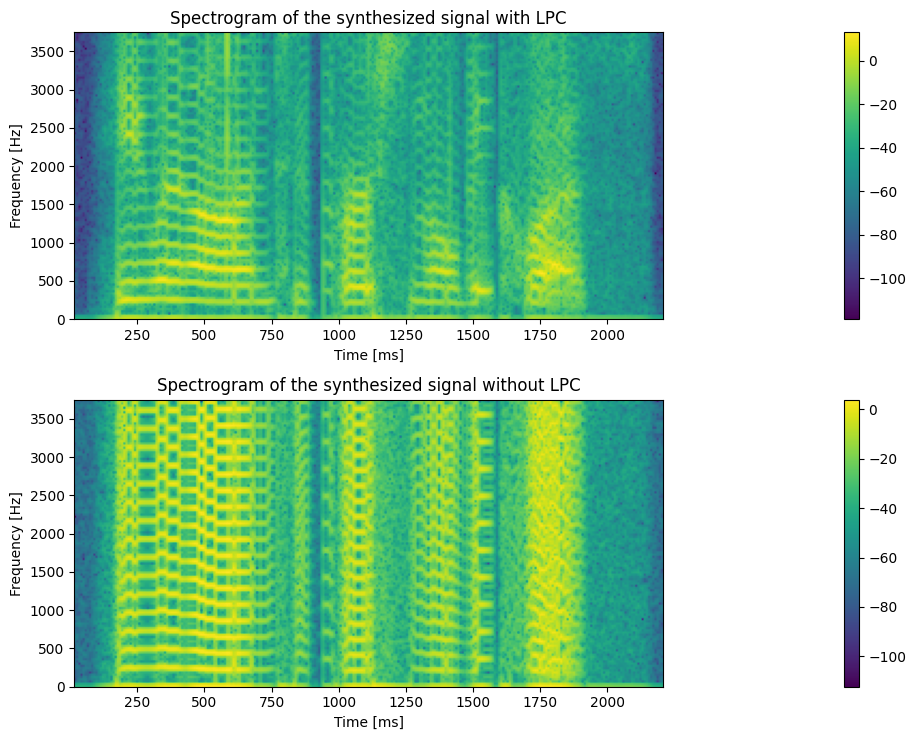

In [346]:
unvoiced_ex = segment_signal(get_unvoiced_signal(len(x)), R)
voiced_ex_with_f0 = get_voiced_signal_with_f0(frequencies, fs, R)
power_per_segment = compute_power_for_all_frames(m_frames)
LPCs = np.zeros((len(m_frames), 10))

output_no_lpc = apply_LPC_to_voiced_unvoiced_e(LPCs, voiced_ex_with_f0, unvoiced_ex, power_per_segment)

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 7.5)

plot_spectrogram(output_with_f, fs, N, R, ax=ax[0], fig=fig)
ax[0].set_title('Spectrogram of the synthesized signal with LPC')

plot_spectrogram(output_no_lpc, fs, 32, R, ax=ax[1], fig=fig)
ax[1].set_title('Spectrogram of the synthesized signal without LPC')

plt.tight_layout()
plt.show()

sd.play(output_no_lpc, fs)
sd.wait()


- Critical for intelligibility are the LPCs, as they model the vocal tract and the formants.
- Critical for speaker recognition are the excitation signals (f0), as they model the individual characteristics of the speaker.
- Gain and unvoiced segments are important for the quality of the signal.

# 4 Quantization

## 4.1 Implementation of a uniform scalar quantizer


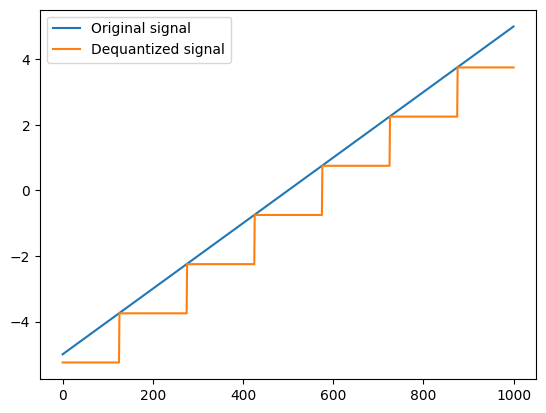

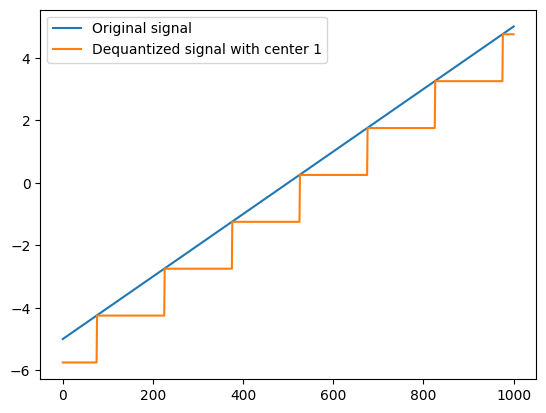

In [347]:
def quantize_encoder(x: np.ndarray , num_bits: int , x_range: float , x_center: float):
    """
    Quantize a signal using a uniform quantizer.

    :param x: the signal to be quantized
    :param num_bits: the number of bits to use for quantization
    :param x_range: the range of the signal
    :param x_center: the center of the signal
    :return: the quantized signal
    """
    # Calculate the step size
    step_size = x_range / (2**num_bits)
    return step_size * np.floor((x - x_center) / step_size +0.5 ) 

def quantize_decoder(x_quantized: np.ndarray , num_bits: int , x_range: float , x_center: float):
    """
    Decode a quantized signal using a uniform quantizer.

    :param x_quantized: the quantized signal
    :param num_bits: the number of bits used for quantization
    :param x_range: the range of the signal
    :param x_center: the center of the signal
    :return: the decoded signal
    """
    # Calculate the step size
    step_size = x_range / (2**num_bits)
    return (np.ceil(x_quantized/step_size)-0.5)*step_size + x_center

test_signal = np.arange(-5, 5.01, 0.01)
quantized_signal = quantize_encoder(test_signal, 2, 6, 0)
dequantized_signal = quantize_decoder(quantized_signal, 2, 6, 0)

plt.plot(test_signal, label='Original signal')
plt.plot(dequantized_signal, label='Dequantized signal')
plt.legend()
plt.show()


quantized_singal_center_1 = quantize_encoder(test_signal, 2, 6, 1)
dequantized_signal_center_1 = quantize_decoder(quantized_singal_center_1, 2, 6, 1)

plt.plot(test_signal, label='Original signal')
plt.plot(dequantized_signal_center_1, label='Dequantized signal with center 1')
plt.legend()
plt.show()

How many quantization levels (or indices) can you realize with n Bits? 
- 2^n

Lets assume you have an input signal with values ranging from -2 to 2 and you choose x_range = 4, and num_bits
= 2. How should you choose x_center? What are the expected quantization levels? The step size between two
quantization levels?
- Da x_range =4, ist das intervall [-2, 2], x_center sollte in der mitte liegen, also 0 sein. Wir haben 4 quantization levels, wo liegen sie? keine Ahnung.

## 4.2 Quantizing the fundamental frequency

How do you choose x_range and x_center based on the maximum and minimum fundamental frequency used in the
estimation process (Section 2)?
- Man kann sich max und min angucken, die differenz daraus ist die range. Und center ist dann die mitte?


Min: 145.45454545454547, Max: 400.0
Zero freq: 127.27272727272727


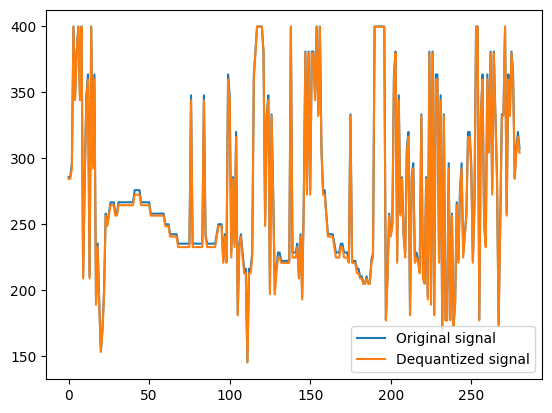

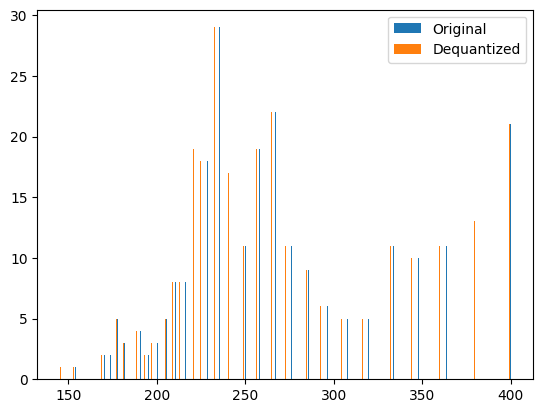

In [348]:
fundamental_frequency, _ = get_fundamental_frequency(x, fs, R, R)
min_freq = np.min(fundamental_frequency)
max_freq = np.max(fundamental_frequency)
freq_range = max_freq - min_freq
print(f"Min: {min_freq}, Max: {max_freq}")

freq_center = (max_freq - min_freq) / 2
print(f"Zero freq: {freq_center}")

number_of_bits = 6
quantized_fundamental_frequencies = quantize_encoder(
    x=fundamental_frequency,
    num_bits=number_of_bits,
    x_range=freq_range,
    x_center=freq_center,
)
dequantized_fundamental_frequencies = quantize_decoder(
    x_quantized=quantized_fundamental_frequencies, 
    num_bits=number_of_bits, 
    x_range=freq_range,
    x_center=freq_center,
)

plt.plot(fundamental_frequency, label='Original signal')
plt.plot(dequantized_fundamental_frequencies, label='Dequantized signal')
plt.legend()
plt.show()

plt.hist(fundamental_frequency, bins=500)
plt.hist(dequantized_fundamental_frequencies, bins=500)
plt.legend(['Original', 'Dequantized'])
plt.show()

voiced_ex_dequantized = get_voiced_signal_with_f0(
    frequencies=dequantized_fundamental_frequencies,
    sampling_rate=fs,
    frame_shift=R,
)
LPCs = compute_lpc(m_frames, 10)
power_per_segment = compute_power_for_all_frames(m_frames)

output_with_f = apply_LPC_to_voiced_unvoiced_e(
    LPCs,
    voiced_ex_dequantized,
    unvoiced_ex,
    power_per_segment,
)

sd.play(output_with_f, fs)
sd.wait()



## 4.3 Quantizing the energy

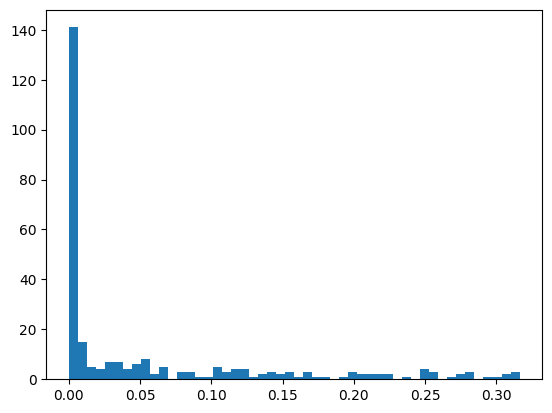

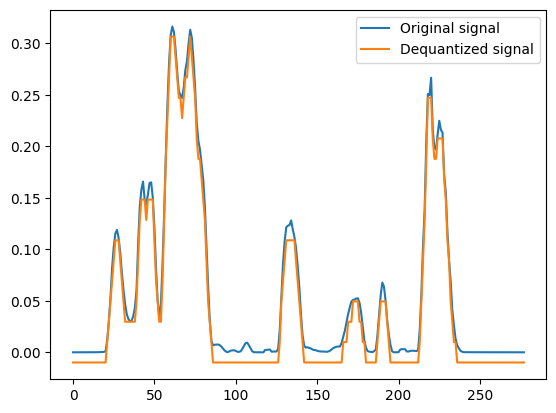

C:\Users\alex_\AppData\Local\Temp\ipykernel_15932\538467452.py:42: RuntimeWarning: invalid value encountered in sqrt
  gain = np.sqrt(power_per_segment[i]/segment_power)


In [349]:
# 4.3
# plot histogram of energy of x
energy = compute_power_for_all_frames(m_frames)
plt.hist(energy, bins=50)
plt.show()

number_of_bits = 4
quantized_energy = quantize_encoder(
    x=energy,
    num_bits=number_of_bits,
    x_range=np.max(energy) - np.min(energy),
    x_center=np.min(energy),
)
dequantized_energy = quantize_decoder(
    x_quantized=quantized_energy,
    num_bits=number_of_bits,
    x_range=np.max(energy) - np.min(energy),
    x_center=np.min(energy),
)

plt.plot(energy, label='Original signal')
plt.plot(dequantized_energy, label='Dequantized signal')
plt.legend()
plt.show()

voiced_ex_dequantized = get_voiced_signal_with_f0(
    frequencies=dequantized_fundamental_frequencies,
    sampling_rate=fs,
    frame_shift=R,
)
LPCs = compute_lpc(m_frames, 10)


output_with_f = apply_LPC_to_voiced_unvoiced_e(
    LPCs,
    voiced_ex_with_f0, 
    unvoiced_ex,
    power_per_segment=dequantized_energy
)
sd.play(output_with_f, fs)
sd.wait()

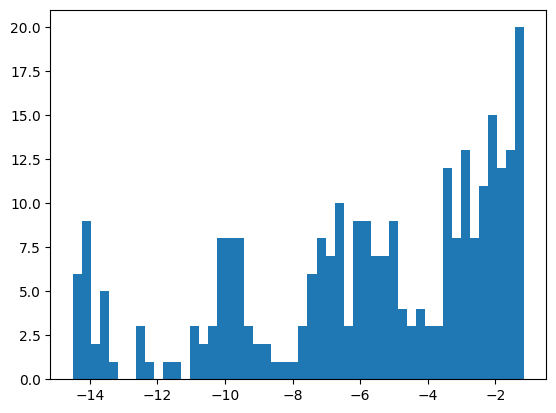

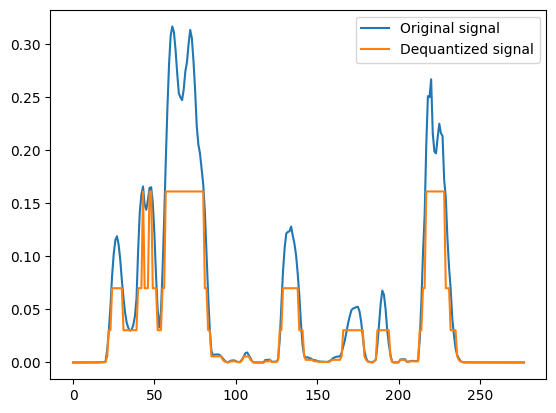

In [350]:
energy_log = np.log(energy)
plt.hist(energy_log, bins=50)
plt.show()

number_of_bits = 4
quantized_energy = quantize_encoder(
    x=energy_log,
    num_bits=number_of_bits,
    x_range=np.max(energy_log) - np.min(energy_log),
    x_center=(np.max(energy_log) - np.min(energy_log)/2),
)
dequantized_energy = quantize_decoder(
    x_quantized=quantized_energy,
    num_bits=number_of_bits,
    x_range=np.max(energy_log) - np.min(energy_log),
    x_center=(np.max(energy_log) - np.min(energy_log)/2),
)
dequantized_energy = np.exp(dequantized_energy)

plt.plot(energy, label='Original signal')
plt.plot(dequantized_energy, label='Dequantized signal')
plt.legend()
plt.show()


output_with_f = apply_LPC_to_voiced_unvoiced_e(
    LPCs,
    voiced_ex_dequantized,
    unvoiced_ex,
    power_per_segment=dequantized_energy
)
sd.play(output_with_f, fs)
sd.wait()

How many bits do you need to quantize the energy of the signal?
- ~4 bits

What is the reason for taking the logarithm?
- Energy of voice signals is not linear, but logarithmic

What is the better choice her: linear or logarithmic quantization?
- logarithmic, but logarithmic 